initial construction of the model, find how the implicit method works, 
todo:build a implicit class later

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from math import sqrt, log, exp
from scipy import stats, linalg, interpolate
import numpy as np
import scipy
import random

from IPython.core.display import display, HTML
import json

In [4]:
def plot3D(X, Y, Z, height=600, xlabel = "Sigma", ylabel = "K", zlabel = "Option Price", initialCamera = None):
    options = {
        "width": "100%",
        "style": "surface",
        "showPerspective": True,
        "showGrid": True,
        "showShadow": False,
        "keepAspectRatio": True,
        "height": str(height) + "px"
    }
    if initialCamera:
        options["cameraPosition"] = initialCamera
    data = [ {"x": X[y,x], "y": Y[y,x], "z": Z[y,x]} for y in range(X.shape[0]) for x in range(X.shape[1]) ]
    visCode = r"""
       <link href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.css" type="text/css" rel="stylesheet" />
       <script src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.js"></script>
       <div id="pos" style="top:0px;left:0px;position:absolute;"></div>
       <div id="visualization"></div>
       <script type="text/javascript">
        var data = new vis.DataSet();
        data.add(""" + json.dumps(data) + """);
        var options = """ + json.dumps(options) + """;
        var container = document.getElementById("visualization");
        var graph3d = new vis.Graph3d(container, data, options);
        graph3d.on("cameraPositionChange", function(evt)
        {
            elem = document.getElementById("pos");
            elem.innerHTML = "H: " + evt.horizontal + "<br>V: " + evt.vertical + "<br>D: " + evt.distance;
        });
       </script>
    """
    htmlCode = "<iframe srcdoc='"+visCode+"' width='100%' height='" + str(height) + "px' style='border:0;' scrolling='no'> </iframe>"
    display(HTML(htmlCode))

option parameters

In [5]:
# 0 : Call / 1: Put
CallPut = 0;

DaysPerYear = 365
Days = 120
T = 0.3
S_0 = 105
K = 100
r = 0.1
sigma = 0.2

In [6]:
TGrid = 100
SGrid = 100
Smax = 5 * S_0
Tmax = Days / DaysPerYear
KGrid = np.linspace(0, Smax, SGrid)
T = np.linspace(0, Tmax, TGrid)
dt = T[1] - T[0]
dS = KGrid[1] - KGrid[0]
prices = np.zeros((SGrid, TGrid))

if CallPut == 0:
    prices[:,TGrid - 1] = np.maximum(KGrid - K, 0)
    prices[SGrid - 1,:] = (KGrid[SGrid - 1] - K) * np.exp((r) * T)
    prices[1,:] = 0
elif CallPut == 1:
    prices[:,TGrid - 1] = np.maximum(K - KGrid, 0)
    prices[SGrid - 1,:] = 0
    prices[1,:] = (K - KGrid[SGrid - 1]) * np.exp((r) * T) 

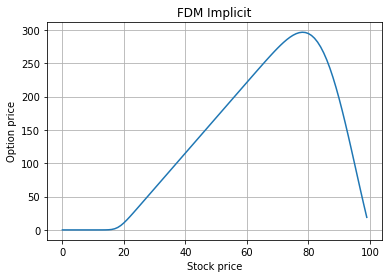

9.806941172478005


In [7]:
a = 0.5 * dt*((r)/dS - sigma**2 * KGrid/(dS**2)) * KGrid
b = 1 + dt * (sigma**2 * KGrid**2/(dS**2) + (r))
c = - 0.5 * dt*((r)/dS + sigma**2 * KGrid/(dS**2)) * KGrid

coeff = np.diag(a[2:SGrid],-1) + np.diag(b[1:SGrid]) + np.diag(c[1:SGrid-1],1)
P, L, U = scipy.linalg.lu(coeff)
Boundary = np.zeros((SGrid - 1,1))

for j in range(TGrid - 2, 0, -1) :
    Boundary[0] = - a[2] * prices[1,j]
    prices[1:SGrid, j:j+1] = (linalg.inv(U).dot(linalg.inv(L).dot(prices[1:SGrid, (j + 1):(j + 2)] + Boundary)))

plt.plot(prices[:,1])
plt.title('FDM Implicit')
plt.ylabel('Option price')
plt.xlabel('Stock price')
plt.grid(True)
plt.show()
impFDMPrice = interpolate.interp1d(KGrid, prices[:,1])(S_0)
print(impFDMPrice)

all values on 3D mesh

In [13]:
X, Y = np.meshgrid(np.linspace(0,100,200),np.linspace(0,100,200))
Z = prices
plot3D(X, Y, Z) 